### Importando Bibliotecas e Dados

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display            import Markdown
from sklearn.preprocessing      import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from skopt import gp_minimize

#### Funções auxiliares

In [20]:
warnings.filterwarnings("ignore")

def df_informations(df):
    df_info = pd.DataFrame({'Not Null': df.notnull().count(),
                'Null': df.isnull().sum(),
                'Perce Null': df.isnull().mean(),
                'Unique': df.nunique(),
                'Dtype': df.dtypes
                })

    df_dtype = df_info['Dtype'].value_counts().reset_index()
    df_dtype.columns = ['Dtype', 'Count']
    df_dtype['Perce'] = round(df_dtype['Count'] / df_dtype['Count'].sum(), 2)

    text = f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns. From these, we have:'

    df_info = df_info.style.background_gradient(cmap='jet', subset=['Perce Null']).format({'Perce Null': '{:.2%}'})
    df_dtype = df_dtype.style.background_gradient(cmap='YlGn', subset=['Perce']).format({'Perce': '{:.2%}'})

    display(Markdown("<H3 style='text-align:left;float:lfet;'>Information about the Dataset"))
    display(Markdown(f'<H5> {text}'))
    display(df_info)
    display(Markdown("<H3 style='text-align:left;float:lfet;'>About Dtypes we have:"))
    display(df_dtype)

def cv_classi(Modelo, X, y, Resultado_recall, Resultado_precision):
    for repet in range(15):
        print('Repetição: ', repet)
        kf1 = KFold(5, shuffle=True, random_state=repet)

        for linhas_treino, linhas_valid in kf1.split(X = X, y=y):
            print("Treino", linhas_treino.shape[0]) 
            print("Valid", linhas_valid.shape[0])
        

            X_treino, X_valid = X.iloc[linhas_treino], X.iloc[linhas_valid]
            y_treino, y_valid = y.iloc[linhas_treino], y.iloc[linhas_valid]

            Modelo

            print('Repetição:',repet)
            
            Modelo.fit(X_treino, y_treino)

            p = Modelo.predict(X_valid)
            Recall = recall_score(y_valid, p)
            precision = precision_score(y_valid, p)
            Resultado_precision.append(precision)
            Resultado_recall.append(Recall)
            
            print('Recall:', Recall)
            print('Precision:',precision)
            print()

#### Carregamendo dos dados

In [21]:
data = pd.read_csv("streaming_data.csv")

### Análise Descritiva

In [22]:
df_informations(data)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 77884 rows and 10 columns. From these, we have:

,Not Null,Null,Perce Null,Unique,Dtype
Age,77884,11277,14.48%,52,float64
Gender,77884,14516,18.64%,2,object
Time_on_platform,77884,21420,27.50%,8721,float64
Devices_connected,77884,25188,32.34%,5,float64
Subscription_type,77884,25221,32.38%,3,object
Num_streaming_services,77884,68312,87.71%,4,float64
Num_active_profiles,77884,0,0.00%,5,int64
Avg_rating,77884,17270,22.17%,401,float64
Churned,77884,16736,21.49%,2,float64
User_id,77884,0,0.00%,65481,object


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Count,Perce
0,float64,6,60.00%
1,object,3,30.00%
2,int64,1,10.00%


In [23]:
data.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
Age,66607.0,43.511072,15.043158,18.0,18.00,23.0,30.00,43.00,57.0,64.0,69.00,69.0
Time_on_platform,56464.0,4385.848505,2526.580859,0.0,82.00,893.0,2196.00,4384.00,6573.0,7891.0,8675.00,8759.0
Devices_connected,52696.0,2.995370,1.414072,1.0,1.00,1.0,2.00,3.00,4.0,5.0,5.00,5.0
Num_streaming_services,9572.0,2.496239,1.120700,1.0,1.00,1.0,1.00,2.00,4.0,4.0,4.00,4.0
Num_active_profiles,77884.0,3.002273,1.413235,1.0,1.00,1.0,2.00,3.00,4.0,5.0,5.00,5.0
Avg_rating,60614.0,3.002252,1.154963,1.0,1.04,1.4,1.99,3.01,4.0,4.6,4.96,5.0
Churned,61148.0,0.243066,0.428938,0.0,0.00,0.0,0.00,0.00,0.0,1.0,1.00,1.0


Existem alguns valores nulos no dataset iremos explorar mais a frente e realizar os tratamentos, quanto a distribuição não existe nenhuma anormalidade muito grande em nenhuma das colunas.

Como manda o edital devemos preencher as colunas Time_on_platform, Num_streaming_services, Churned, Avg_rating e Devices_connected por 0 e dropas as linhas nulas em Gender, Subscription_type e Age.

In [24]:
data["Time_on_platform"].fillna(0, inplace=True)
data["Num_streaming_services"].fillna(0, inplace=True)
data["Churned"].fillna(0, inplace=True)
data["Avg_rating"].fillna(0, inplace=True)
data["Devices_connected"].fillna(0, inplace=True)
data.dropna(subset=["Gender", "Subscription_type", "Age"], inplace=True)

In [25]:
df_informations(data)

<H3 style='text-align:left;float:lfet;'>Information about the Dataset

<H5> Dataset has 36515 rows and 10 columns. From these, we have:

,Not Null,Null,Perce Null,Unique,Dtype
Age,36515,0,0.00%,52,float64
Gender,36515,0,0.00%,2,object
Time_on_platform,36515,0,0.00%,8069,float64
Devices_connected,36515,0,0.00%,6,float64
Subscription_type,36515,0,0.00%,3,object
Num_streaming_services,36515,0,0.00%,5,float64
Num_active_profiles,36515,0,0.00%,5,int64
Avg_rating,36515,0,0.00%,402,float64
Churned,36515,0,0.00%,2,float64
User_id,36515,0,0.00%,30739,object


<H3 style='text-align:left;float:lfet;'>About Dtypes we have:

,Dtype,Count,Perce
0,float64,6,60.00%
1,object,3,30.00%
2,int64,1,10.00%


### Análise Exploratória

In [26]:
col_categ = list(data.select_dtypes("object").columns)
col_num = list(data.select_dtypes(np.number).columns)

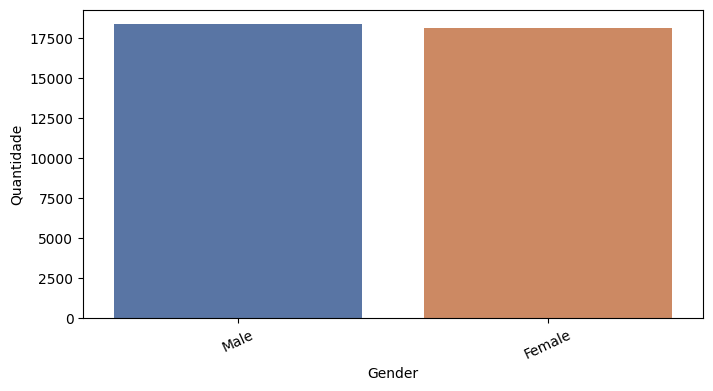

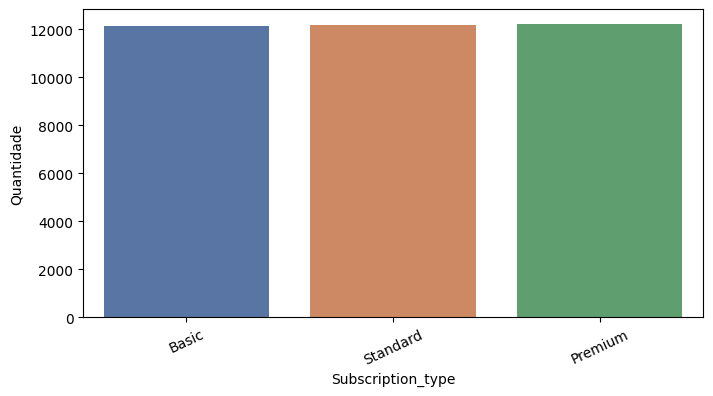

In [27]:
for categ in col_categ:
        if categ != "User_id":
                plt.figure(figsize=(8,4))
                ax = sns.countplot(data=data, x=categ, palette="deep")
                plt.xticks(rotation=25)
                ax.set_ylabel("Quantidade")
                plt.show()

IndexError: index 6 is out of bounds for axis 0 with size 6

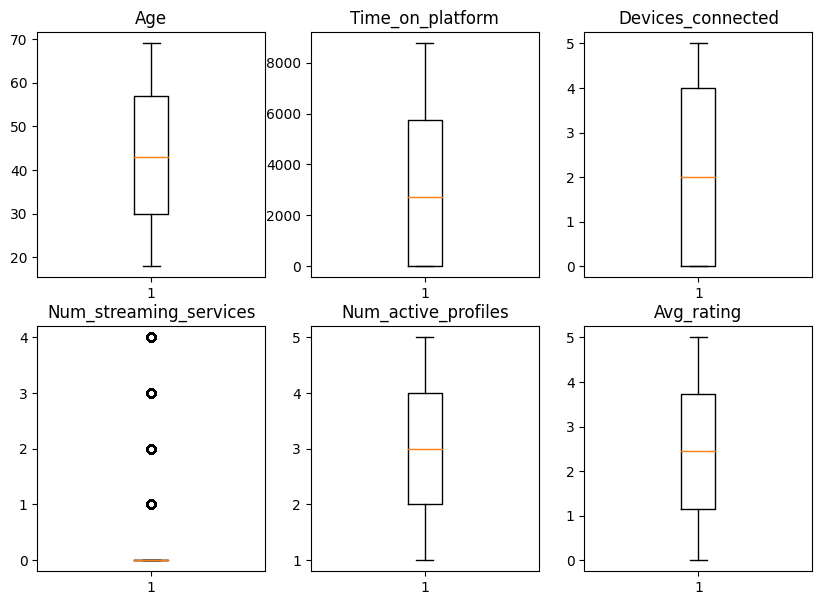

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
axs = axs.flatten()

# Loop para criar os boxplots
for i in range(len(col_num)):
        axs[i].boxplot(data[col_num[i]])
        axs[i].set_title(col_num[i])
        
# Ajuste dos subplots
plt.tight_layout()

# Mostrar o gráfico
plt.show()

Como podemos a coluna Num_streaming_services possui alguns outliers. 

### Pré Processamento dos dados

Antes de iniciar o pré processamento irei fazer o split dos dados para evitar que ocorra data leakage.

In [ ]:
data["Churned"] = data["Churned"].map({"No": 0, "Yes": 1})

X = data.drop("Churned", axis=1)
y = data.Churned

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
"""Para o encoder das variáveis iremos utilizar o target encoder pois alguns dos modelos que desejo utilizar será baseado em árvores."""

col_num = X_train.select_dtypes(np.number).columns.to_list()

target_encoder = ce.TargetEncoder()

X_train = target_encoder.fit_transform(X_train, y_train)

X_test = target_encoder.transform(X_test)

In [ ]:
"""Agora iremos utilizar o MinMaxScaler para redimensionar os dados"""

scaler = MinMaxScaler()
X_train[col_num] = scaler.fit_transform(X_train[col_num])
X_test[col_num] = scaler.transform(X_test[col_num])

#### Modelo de Regressão Logística.

Para Tunning do modelo optei pelo Bayesian Optimization que permite eu passar o intervalo que desejo e me retorna os melhores parâmetros, como estamos lidando com dados desbalanceados irei deixar o parâmetro class_weight fixo como 'balanced'.

In [ ]:
def treinar_modelo(params):
    C = params[0]
    max_iter = params[1]
    solver = params[2]

    print(params, '\n')
    

    mdl = LogisticRegression(class_weight='balanced',
                             C=C, 
                             max_iter=max_iter,
                             penalty='l2',
                             solver = solver,
                             random_state=1)

    mdl.fit(X_train, y_train)

    p = mdl.predict(X_test)

    return -recall_score(y_test, p)


space = [(0.01, 10.0), # C
         (50, 4000), # max_iter
         ('saga', 'lbfgs','sag')] # solver
Bay_LR = gp_minimize(treinar_modelo, space, n_calls=15, random_state=1, verbose = 0)

[9.971876261279299, 3734, 'lbfgs'] 

[9.990414748088208, 983, 'sag'] 

[3.885228304208455, 2695, 'saga'] 

[8.464646057693313, 1287, 'sag'] 

[4.440094408857772, 957, 'sag'] 

[9.14048062554654, 1856, 'sag'] 

[9.391886616342024, 3125, 'sag'] 

[8.029547464334277, 417, 'sag'] 

[8.651552317270045, 3325, 'saga'] 

[2.7377692424253066, 284, 'sag'] 

[5.934724527797589, 1742, 'lbfgs'] 

[9.968468950397423, 1559, 'sag'] 

[0.10954350152298836, 3955, 'lbfgs'] 

[0.01, 4000, 'saga'] 

[0.01, 50, 'lbfgs'] 



In [ ]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('C =',Bay_LR.x[0])
print('max_iter =',Bay_LR.x[1])
print('solver =',Bay_LR.x[2])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

C = 9.971876261279299
max_iter = 3734
solver = lbfgs


In [ ]:
Result_LR_Recall = []
Result_LR_Precision = []
Model_LR = LogisticRegression(C = Bay_LR.x[0],
                           max_iter = Bay_LR.x[1],
                           class_weight='balanced',
                           penalty = 'l2',
                           solver=Bay_LR.x[2], random_state=1)

Agora que já temos os melhores parâmetros do modelo irei passar esses valores na validação cruzada, a validação cruzada servce para evitar que o modelo sofra over ou underfitting.

In [ ]:
cv_classi(Model_LR, X_train, y_train, Result_LR_Recall, Result_LR_Precision)

Repetição:  0
Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17528
Valid 4381
Repetição: 0
Recall: 1.0
Precision: 1.0

Repetição:  1
Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17528
Valid 4381
Repetição: 1
Recall: 1.0
Precision: 1.0

Repetição:  2
Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17528
Valid 4381
Repetição: 2
Recall: 1.0

In [ ]:
pred_LR = Model_LR.predict(X_test)
Recall_LR = recall_score(y_test, pred_LR)
Precision_LR = precision_score(y_test, pred_LR)
Accuracy_LR = accuracy_score(y_test, pred_LR)

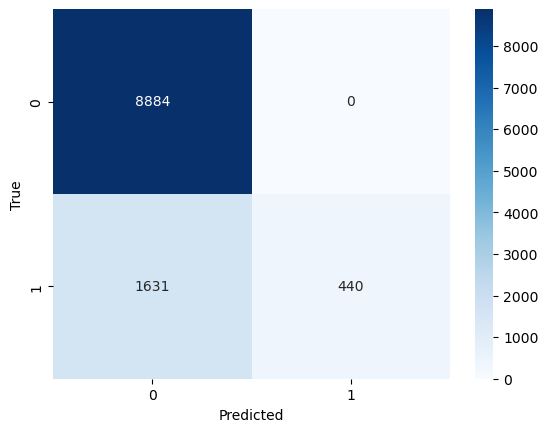

In [ ]:
cm_LR = confusion_matrix(y_test, pred_LR)
sns.heatmap(cm_LR, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(f'O modelo de Logistic Regression apresentou um índice de Recall de {round(Recall_LR*100,2)}%, Precision de {round(Precision_LR*100,2)}%') 

O modelo de Logistic Regression apresentou um índice de Recall de 19.51%, Precision de 100.0%


#### Modelo de Random Forest

In [ ]:
def treinar_modelo_RF(params):
    criterion = params[0]
    max_depth = params[1]
    n_estimators = params[2]

    print(params, '\n')
    

    mdl_RF = RandomForestClassifier(criterion=criterion,
                                    max_depth = max_depth,
                                    n_estimators = n_estimators,
                                    random_state=1)

    mdl_RF.fit(X_train, y_train)

    p = mdl_RF.predict(X_test)

    return -recall_score(y_test, p)


space = [("entropy", "gini"), # criterion
         (2, 10), # max_depth
         (100, 500)] # N_Estimators

Bay_RF = gp_minimize(treinar_modelo_RF, space, n_calls=15, random_state=1, verbose = 0)

['gini', 9, 151] 

['gini', 4, 259] 

['entropy', 7, 474] 

['gini', 5, 310] 

['entropy', 4, 314] 

['gini', 6, 272] 

['gini', 8, 386] 

['gini', 3, 307] 

['gini', 9, 432] 

['entropy', 2, 368] 

['gini', 5, 198] 

['gini', 5, 386] 

['entropy', 10, 102] 

['entropy', 2, 100] 

['entropy', 10, 500] 



In [ ]:
print('Os parâmetros escolhidos pelo Bayesian Optimization foram:')
print()
print('Criterion =',Bay_RF.x[0])
print('max_depth =',Bay_RF.x[1])
print('N_Estimators =',Bay_RF.x[2])

Os parâmetros escolhidos pelo Bayesian Optimization foram:

Criterion = gini
max_depth = 9
N_Estimators = 151


In [ ]:
Result_RF_Recall = []
Result_RF_Precision = []
Model_RF = RandomForestClassifier(criterion = Bay_RF.x[0],
                                    max_depth = Bay_RF.x[1],
                                    n_estimators=Bay_RF.x[2],
                                    random_state=1)

In [ ]:
cv_classi(Model_RF, X_train, y_train, Result_RF_Recall, Result_RF_Precision)

Repetição:  0
Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 0
Recall: 1.0
Precision: 1.0

Treino 17528
Valid 4381
Repetição: 0
Recall: 1.0
Precision: 1.0

Repetição:  1
Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 1
Recall: 1.0
Precision: 1.0

Treino 17528
Valid 4381
Repetição: 1
Recall: 1.0
Precision: 1.0

Repetição:  2
Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17527
Valid 4382
Repetição: 2
Recall: 1.0
Precision: 1.0

Treino 17528
Valid 4381
Repetição: 2
Recall: 1.0

In [ ]:
pred_RF = Model_RF.predict(X_test)
Recall_RF = recall_score(y_test, pred_RF)
Precision_RF = precision_score(y_test, pred_RF)

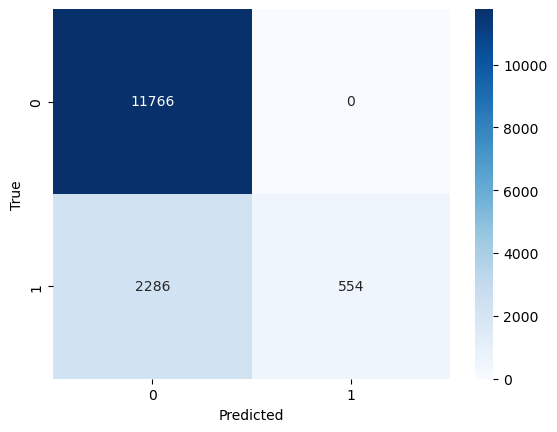

In [ ]:
cm_LR = confusion_matrix(y_test, pred_RF)
sns.heatmap(cm_LR, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(f'O modelo de Random Forest apresentou um índice de Recall de {round(Recall_RF*100,2)}% e Precision de {round(Precision_RF*100,2)}%') 

O modelo de Random Forest apresentou um índice de Recall de 19.51% e Precision de 100.0%
